# Calculating the Error Rate for Category Prediction

## Introduction

In this notebook, I try to calculate the error rate for the correlation between Word2Vec's cosine similarity score of similar artists and the artists' art historical labels. I find that while there is a high error rate, above 80%, there is also a slightly negative correlation between a category's mean error and its number of members. 

## Method

Each artist record from the MoMA dataset includes a Wikidata ID. Using this, I queried the Wikidata Sparql database to collect the zero or more movements to which an artist can belong. Out of a total TK artist in the model, TK were labeled. This ratio does not reflect artists belonging to less than TK exhibition nodes. They were excluded from labeling, which means TK out of TK were labeled. [Could be said more clearly.] 

Categories were added to the project's graph dataset as individual nodes, where each edge connects a node of type artist, who is a member of the category. Categories with less than two artists were exluced. The number of categories included is TK. 

Each artist in the graph includes 10 similar artists edges. These edges are weighted with a cosine similarity score generated by the Word2Vec model. The mean score is TK.

In order to find the error rate, unlabled similar artists were excluded, because it's not known whether they do or do not belong to a category.

With this network of included categories and artists, it's now possible to calculate the P-value for each artist. This was done by 

$$P = \frac{\sum{Misses}}{\sum{Hits} + \sum{Misses}}$$

Where *Hits* and *Misses* are cosine similarity scores. 

With this list of scores two reports were produced: One for mean error rates per category and one for the total mean error rate.  

In [13]:
import sys
sys.path.append('../bin')

from pprint import pprint
import matplotlib.pyplot as plt

import utils
import constants as c


In [23]:
def get_labeled_nodes(cat):
    labeled = set()
    for c in cat:
        for m in c.edges:
            labeled.add(m)
    return labeled

def mean(s):
    return sum([x for x in s]) / len(s)

def diff_sq(s):
    return [(x - mean(s))**2 for x in s]

def variance(s):
    return sum(diff_sq(s)) / len(s)

def score_category(graph, cat, all_labeled_nodes):
    # Score is misses / (hits + misses)
    scores = []
    for m in cat.edges:
        A = graph[m]
        hits = []
        misses = []
        for token, score in A.similar:        
            # Hits: token is in cat.edges
            if token in cat.edges:
                hits.append(score)
            # Misses: token is labeled but not as this category
            if token in all_labeled_nodes and token not in cat.edges:
                misses.append(score)
        if len(misses) + len(hits) == 0:
            # Return 1 for a full on error
            # score = 1
            continue
        else:
            score = sum(misses) / (sum(hits) + sum(misses)) 
            scores.append(score)
    
    if len(scores) == 0:
        return None
    
    return {
        'cat': cat.id, 
        'degrees': cat.degrees, 
        'mean': mean(scores), 
        'variance': variance(scores), 
        'scores': scores,
        'total_hits_misses': len(hits) + len(misses)
    }

def report(lines):
    print(f'{"Category":<15s} {"Mean":>14s} {"Variance":>14s} {"N":>3s}')
    print('---------------------------------------------------')
    for line in lines:
        print(f"{line['cat']:<25s} {line['mean']:<10f} {line['variance']:<10f} {len(line['scores']):<10d}")


## Scores by category

In [24]:
graph = utils.load_graph('similar-labeled-import.pickle')

In [28]:
nodes = graph.get_nodes()
categories = nodes['Category'].values()
labeled_nodes = get_labeled_nodes(categories)    

scores_by_category = []

for category in categories: 
#     Excluded categories
#     if category.degrees <= 1:
#         print(category)
    if category.degrees > 1:
        score = score_category(graph, category, labeled_nodes)
        if score and len(score['scores']) > 5:
            scores_by_category.append(score)

report(scores_by_category)

Category                  Mean       Variance   N
---------------------------------------------------
Post-Impressionism        0.799815   0.022439   15        
Symbolism                 0.760450   0.032440   12        
expressionism             0.672576   0.077314   46        
Impressionism             0.905844   0.009579   11        
pointillism               0.830357   0.029310   6         
Cubism                    0.835317   0.018891   12        
fauvism                   0.861728   0.010154   9         
surrealism                0.835455   0.023371   23        
abstract expressionism    0.535668   0.089418   60        
social realism            0.777778   0.135802   6         
Realism                   0.765986   0.031101   7         
constructivism            0.985714   0.001224   7         
futurism                  0.973611   0.002097   8         
Art Nouveau               0.722222   0.083580   6         
Dada                      0.892772   0.017628   14        
abstract art 

## All scores 

In [26]:
all_scores = []

for category in categories: 
    if category.degrees > 1:
        cat_score = score_category(graph, category, labeled_nodes)
        if cat_score:
            for x in cat_score['scores']:
                all_scores.append(x)

line = {
    'cat': 'all', 
    'mean': mean(all_scores), 
    'variance': variance(all_scores), 
    'scores': all_scores
#     Add hits and misses and cat degrees to reports
}

report([line])

Category                  Mean       Variance   N
---------------------------------------------------
all                       0.803171   0.062211   479       


(array([  9.,   9.,   8.,  13.,  16.,  43.,  34.,  30.,  85., 232.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

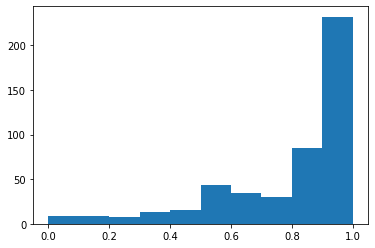

In [27]:
plt.hist(all_scores, cumulative=False)


## What kind of a relationship is there between category mean score and degrees?

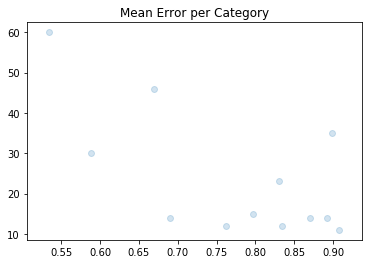

In [19]:
filtered_cat_scores = [x for x in scores_by_category if x['mean'] < 1]
X = [s['mean'] for s in filtered_cat_scores]
Y = [len(s['scores']) for s in filtered_cat_scores]

plt.title('Mean Error per Category')
plt.scatter(X, Y, alpha=0.2)


In [20]:
from scipy import stats

stats.pearsonr(X, Y)

(-0.6630253899024383, 0.018768765480191903)

In [21]:
stats.levene(X, Y, center='median')

LeveneResult(statistic=6.62086531633264, pvalue=0.017347052319629346)

In [22]:
stats.linregress(X, Y)

LinregressResult(slope=-83.86151860861263, intercept=88.6646621193521, rvalue=-0.6630253899024384, pvalue=0.018768765480191876, stderr=29.94198528530188)

## Conclusion

